In [11]:
# %%
from pathlib import Path 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from napatrackmater.Trackvector import (TrackVector,
                                        SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        
                                        )

In [12]:
dataset_name = 'Fifth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')
master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))

goblet_basal_radial_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted.csv')

save_dir = os.path.join(tracking_directory, f'neighbour_plots_predicted/')
Path(save_dir).mkdir(exist_ok=True, parents=True)

shape_cols = SHAPE_FEATURES
dynamic_cols = DYNAMIC_FEATURES
feature_cols = SHAPE_DYNAMIC_FEATURES

neighbour_radius = 70 #pixels


In [13]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax

tracks_goblet_basal_radial_dataframe = pd.read_csv(goblet_basal_radial_dataframe)

Reading Master XML


In [14]:
neighbour_dataframe = tracks_goblet_basal_radial_dataframe[~tracks_goblet_basal_radial_dataframe['Cell_Type'].isna()]

In [15]:


def find_neighbors_within_radius(df, R):
    neighbors_dict = {}
    unique_track_ids = df['Track ID'].unique()
    unique_time_points = df['t'].unique()
    for track_id in unique_track_ids:
        neighbors_dict[track_id] = {}
        
        for time_point in unique_time_points:
            current_tracks = df[(df['Track ID'] == track_id) & (df['t'] == time_point)]
            
            if not current_tracks.empty:
                current_track = current_tracks.iloc[0]
                current_coords = np.array([current_track['z'], current_track['y'], current_track['x']])
                
                time_filtered_df = df[df['t'] == time_point]
                distances = np.sqrt((time_filtered_df['z'] - current_coords[0])**2 + 
                                    (time_filtered_df['y'] - current_coords[1])**2 + 
                                    (time_filtered_df['x'] - current_coords[2])**2)
                
                neighbor_indices = time_filtered_df[distances <= R].index
                neighbor_cell_types = time_filtered_df.loc[neighbor_indices, 'Cell_Type'].tolist()
                neighbors_dict[track_id][time_point] = neighbor_cell_types
    
    return neighbors_dict

In [16]:
neighbors_dict = find_neighbors_within_radius(neighbour_dataframe, neighbour_radius)

In [17]:
from collections import Counter
color_palette = {
    'Basal': '#1f77b4',  
    'Radial': '#ff7f0e',
    'Goblet': '#2ca02c',
}
def plot_for_timepoint(df,neighbors_dict, time_point):
    # Filter the DataFrame for the current time point
    time_filtered_df = df[df['t'] == time_point]
    
    # Create a new figure
    plt.figure(figsize=(10, 8))
    
    # Plot the tracks
    sns.scatterplot(data=time_filtered_df, x='x', y='y', hue='Cell_Type', s=100, palette=color_palette)
    
   
    plt.title(f"Time: {time_point}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.show()
    all_cell_type_types = {}
    for track_id in time_filtered_df['Track ID'].unique():
        track_data = time_filtered_df[time_filtered_df['Track ID'] == track_id].iloc[0]
        neighbors = neighbors_dict.get(track_id, {}).get(time_point, [])
        current_cell_type = track_data['Cell_Type']
        neighbor_counts = Counter(neighbors)
        if current_cell_type in all_cell_type_types:
           current_neighbour_counts = all_cell_type_types[current_cell_type] 
           neighbor_counts+=current_neighbour_counts
           all_cell_type_types[current_cell_type] = neighbor_counts
        else:
           all_cell_type_types[current_cell_type] = neighbor_counts    
       

    
    fig, axs = plt.subplots(len(all_cell_type_types), 1, figsize=(16, len(all_cell_type_types) * 12))

    for ax, center_key in zip(axs, all_cell_type_types):
        neighbors = all_cell_type_types[center_key]
        num_neighbors = len(neighbors) 
        angles = np.linspace(0, 2 * np.pi, num_neighbors, endpoint=False)
        ax.plot(0, 0, 'o', color='black', markersize=15, label=center_key)
        for i, (neigh, count) in enumerate(neighbors.items()):
            x = np.cos(angles[i]) * (count / 100 + 5)  
            y = np.sin(angles[i]) * (count / 100 + 5)
            circle = plt.Circle((x, y), count / 100, color=color_palette.get(neigh, 'grey'), alpha=0.8, label=neigh)
            ax.add_artist(circle)
        ax.set_xlim(-max(neighbors.values()) / 100 - 20, max(neighbors.values()) / 100 + 20)
        ax.set_ylim(-max(neighbors.values()) / 100 - 20, max(neighbors.values()) / 100 + 20)
        ax.set_aspect('equal')
        ax.set_title(f'Neighbors of {center_key}')
        ax.legend(loc='upper right')
        ax.grid(True)

    plt.tight_layout()
    plt.show()
  
    

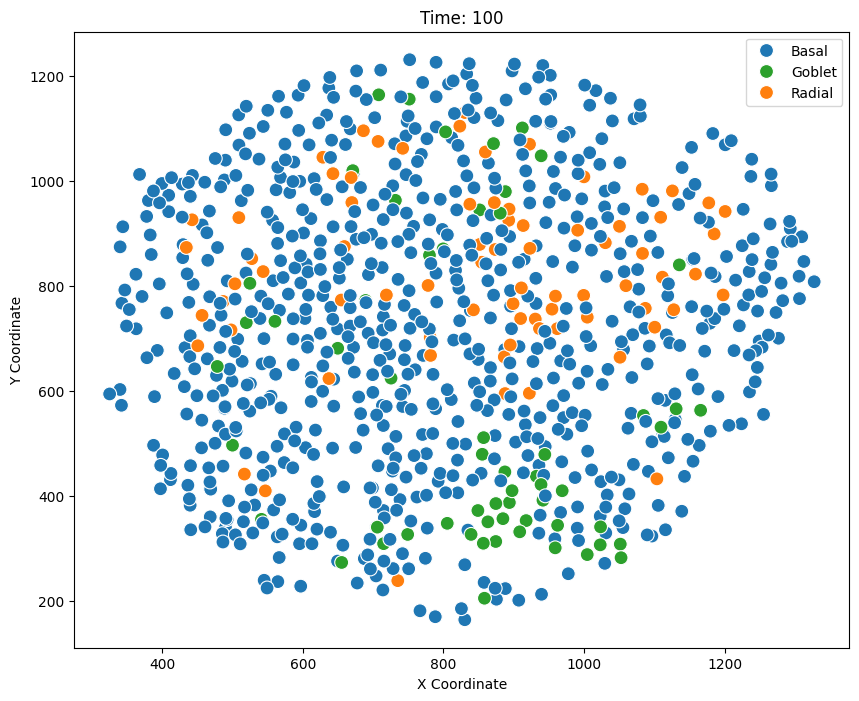

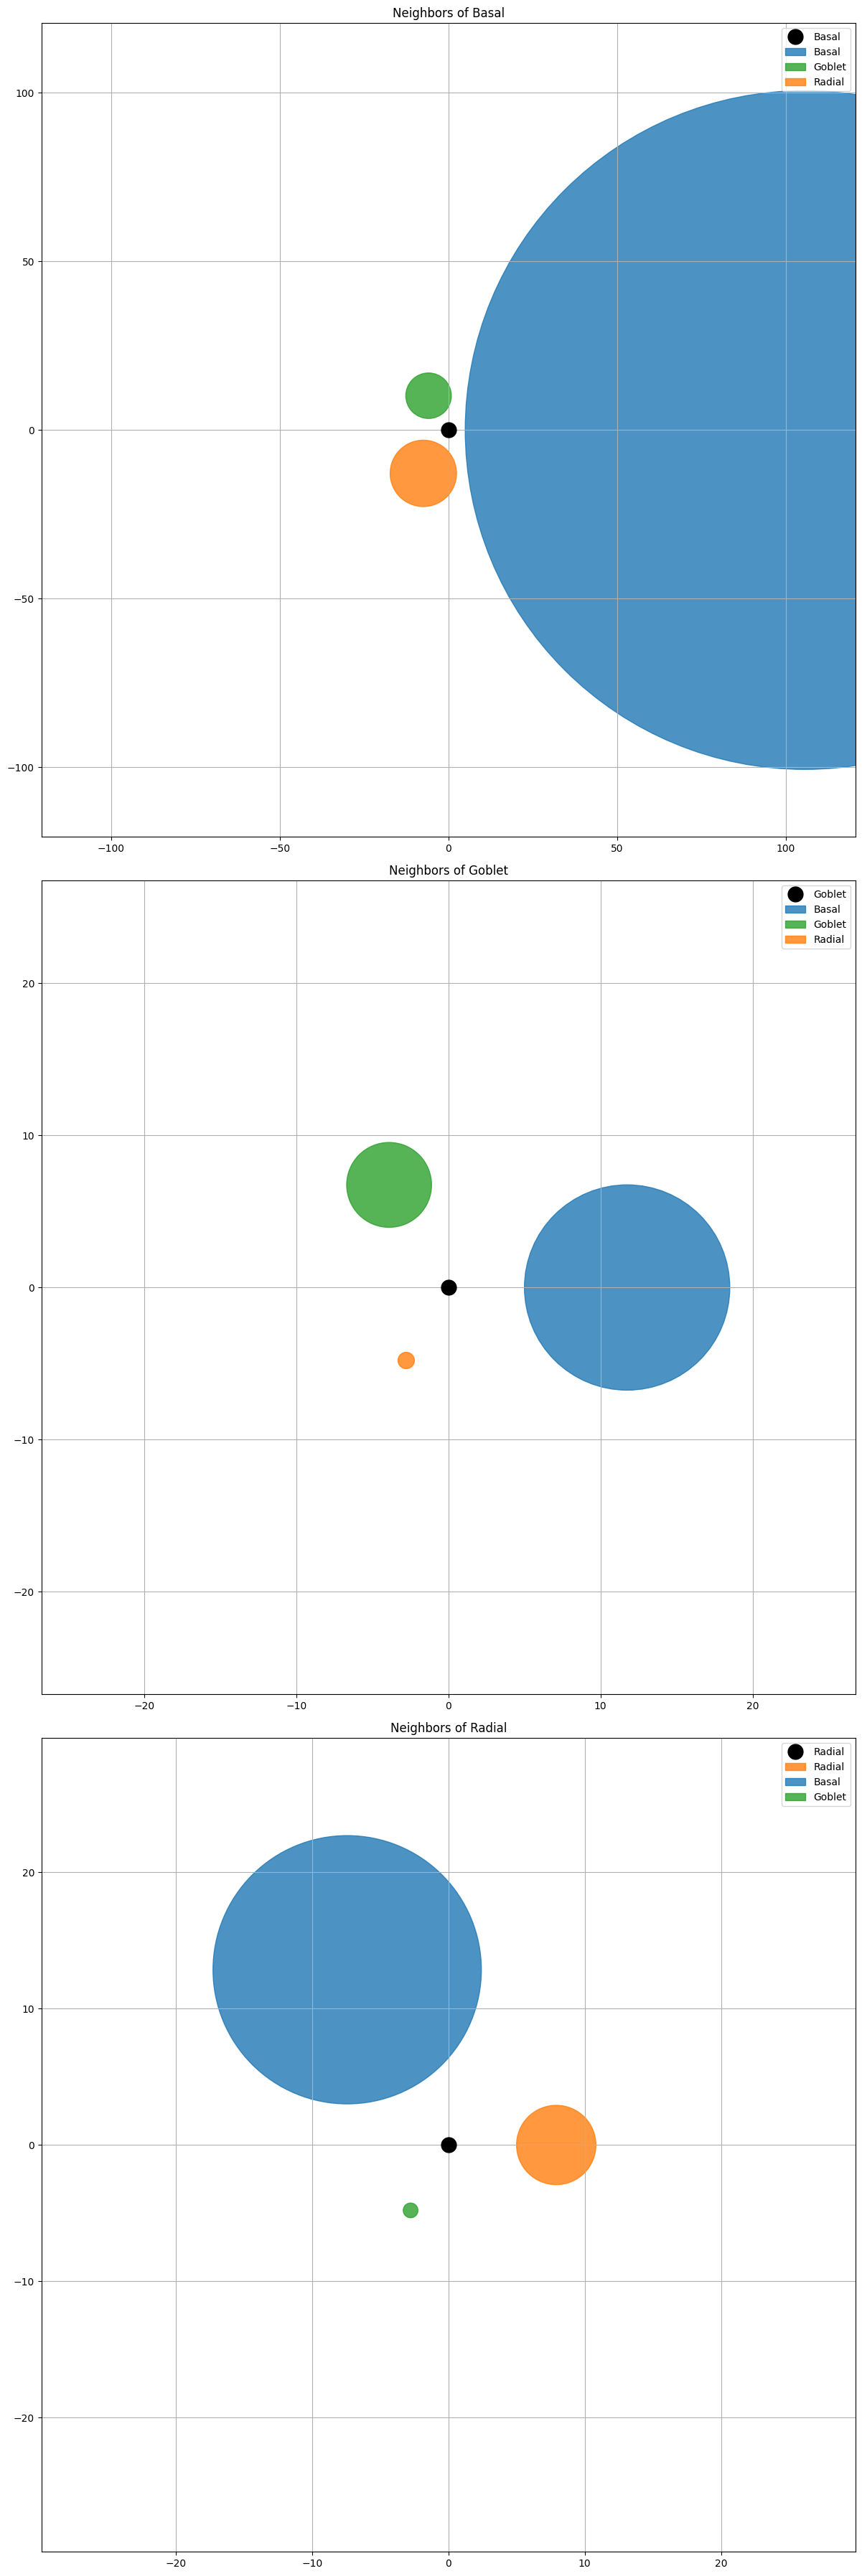

In [18]:
plot_for_timepoint(neighbour_dataframe, neighbors_dict, 100)

In [19]:
def plot_for_all_timepoints(df, neighbors_dict):
    timepoints = sorted(df['t'].unique())
    all_cell_type_types = {cell_type: {tp: Counter() for tp in timepoints} for cell_type in df['Cell_Type'].unique()}

    
    for time_point in timepoints:
        time_filtered_df = df[df['t'] == time_point]

        for track_id in time_filtered_df['Track ID'].unique():
            track_data = time_filtered_df[time_filtered_df['Track ID'] == track_id].iloc[0]
            current_cell_type = track_data['Cell_Type']
            neighbors = neighbors_dict.get(track_id, {}).get(time_point, [])
            neighbor_counts = Counter(neighbors)

            if current_cell_type in all_cell_type_types:
                all_cell_type_types[current_cell_type][time_point] += neighbor_counts

    
    fig, axs = plt.subplots(len(all_cell_type_types), 1, figsize=(16, len(all_cell_type_types) * 6))
    
    if len(all_cell_type_types) == 1:
        axs = [axs] 

   
    for idx, cell_type in enumerate(all_cell_type_types):
        ax = axs[idx]
        neighbor_types = sorted(set(neigh for counts in all_cell_type_types[cell_type].values() for neigh in counts))
        
        for neighbor in neighbor_types:
            y_values = [all_cell_type_types[cell_type][tp].get(neighbor, 0) for tp in timepoints]
            ax.plot(timepoints, y_values, label=f'{neighbor}', color=color_palette.get(neighbor, 'grey'), marker='o')

        ax.set_title(f'Neighbor Counts for Cell Type: {cell_type}')
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Count')
        ax.legend(loc='upper right')
        ax.grid(True)
    fig.savefig(os.path.join(save_dir, 'neighbor_counts.png'))
    plt.tight_layout()
    plt.show()

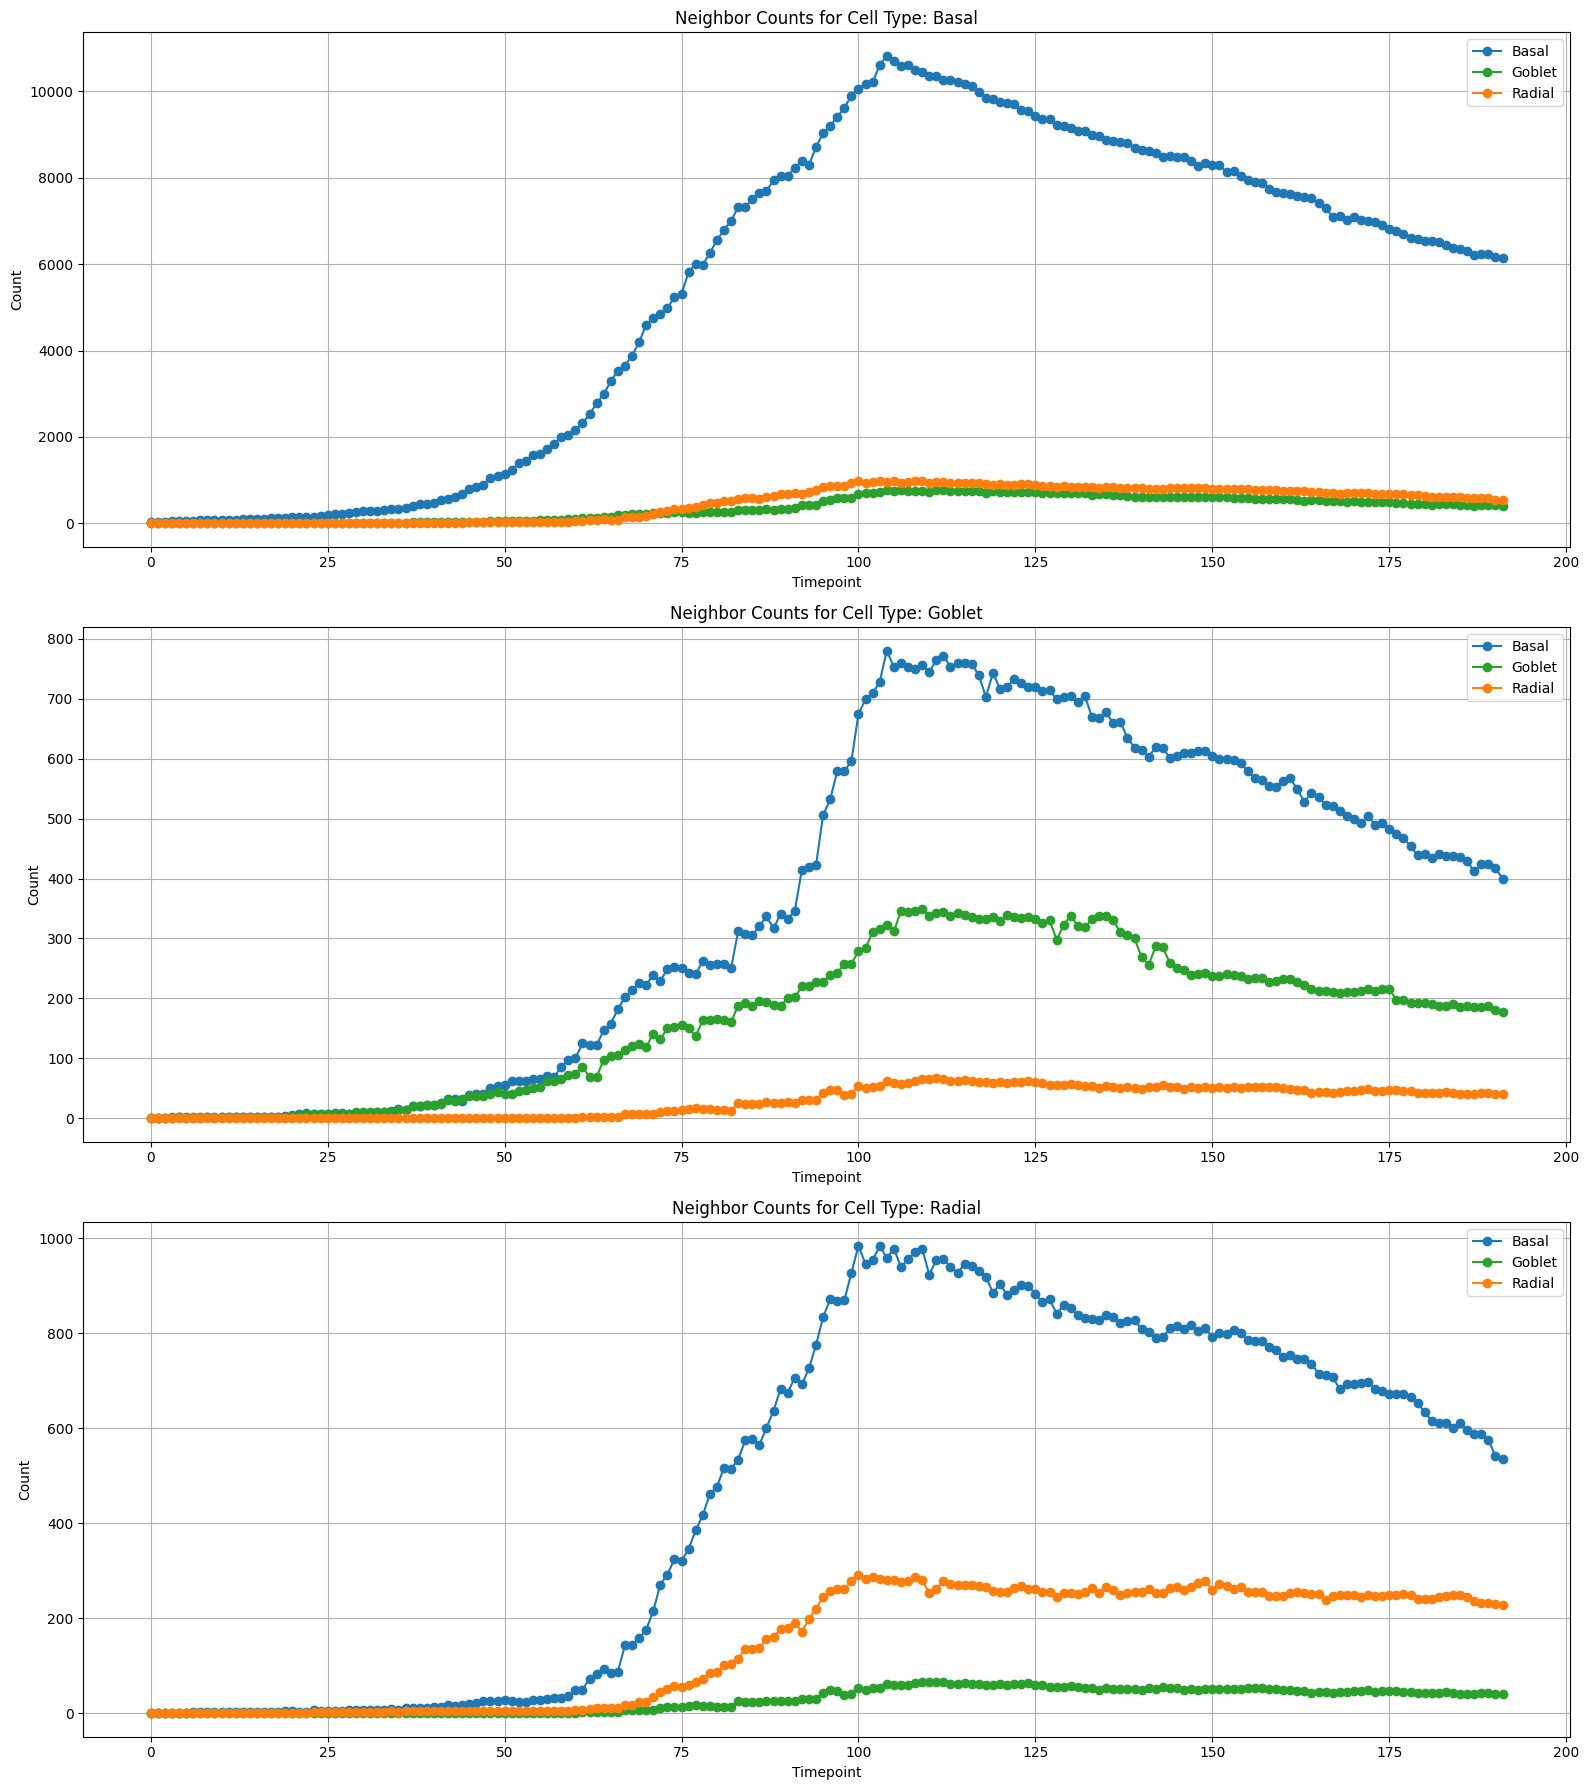

In [20]:
plot_for_all_timepoints(neighbour_dataframe, neighbors_dict)